### Iris Classifier
#### Train with sklearn and log to MLFlow registry

In [3]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import os
import mlflow
from mlflow.models import infer_signature
import matplotlib.pyplot as plt
import pandas as pd
import io

/home/andrew/programming/py/bentoml_example/.venv/lib/python3.10/site-packages/mlflow/protos/service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service


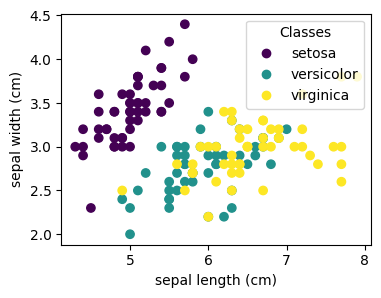

In [8]:
'''Load dataset'''
iris = datasets.load_iris()
_, ax = plt.subplots(figsize=(4,3))
scatter = ax.scatter(iris.data[:,0], iris.data[:,1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(scatter.legend_elements()[0], iris.target_names, loc='upper right', title='Classes')

In [25]:
'''Make df'''
iris_df = pd.concat([pd.DataFrame(iris.data), pd.DataFrame(iris.target)], axis=1)
iris_df.columns = iris.feature_names+['target']
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [26]:
print(iris_df.shape)

(150, 5)


In [ ]:
'''Train and test split'''
def prepare_data(train, test):
    return train_test_split(train, test, test_size=0.25, random_state=4)

X, y = iris_df.iloc[:,:3], iris_df.iloc[:,4]
data = prepare_data(X,y) # X_train, X_test, y_train, y_test

In [48]:
'''Train a simple classifier'''
def train_svc(data, params=None):
    svc = svm.SVC(gamma='scale')
    svc.fit(data[0], data[2]) # X_train, y_train
    return svc

params = {
    'solver': 'lbfgs',
    'max_iter': 100,
    'multi_class': 'auto',
    'random_state': 1
}

svc = train_svc(data, params)

In [49]:
'''Calculate metrics'''
X_train, X_test, y_train, y_test = data # unpack

# Predict on test
y_pred = svc.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f'Model accuracy is: {acc}')
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = iris.target_names, columns= iris.target_names)
print(cm_df)

Model accuracy is: 0.9466666666666667
            setosa  versicolor  virginica
setosa          30           0          0
versicolor       0          20          2
virginica        0           2         21


In [52]:
'''Push model to MLFlow registry'''
def save_to_mlflow(model, params):
    # Start run
    mlflow.autolog()
    mlflow.set_experiment('Iris')
    artifact_path = 'artifacts'
    registered_model_name = 'iris-svc'

    with mlflow.start_run():
        # Logging
        mlflow.log_params(params)
        mlflow.log_metric('accuracy', acc)

        # Tag
        mlflow.set_tag('Info', 'Iris and Support Vector Machine Classifier, from sklearn')

        # Log model
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=artifact_path,
            registered_model_name=registered_model_name
        )
    return model_info

model_info = save_to_mlflow(svc, params)
print(model_info)

2025/01/09 12:22:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Registered model 'iris-svc' already exists. Creating a new version of this model...
Created version '2' of model 'iris-svc'.


In [54]:
'''Return key information'''
print(f'uuid: {model_info.model_uuid}')
print(f'runid: {model_info.run_id}')
print(f'uri: {model_info.model_uri}')
print(f'flavour: {model_info.flavors}')

uuid: 00eb22fdbf274e74b4e12a31373f3a88
runid: fcaee89aad284110ac6d2c82c4bf7e70
uri: runs:/fcaee89aad284110ac6d2c82c4bf7e70/artifacts
flavour: {'python_function': {'model_path': 'model.pkl', 'predict_fn': 'predict', 'loader_module': 'mlflow.sklearn', 'python_version': '3.10.12', 'env': {'conda': 'conda.yaml', 'virtualenv': 'python_env.yaml'}}, 'sklearn': {'pickled_model': 'model.pkl', 'sklearn_version': '1.4.2', 'serialization_format': 'cloudpickle', 'code': None}}
